
TODO: Coarsen the shape for analysis

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects
  - TODO: Fix issue that we can't load the csv of the pilot subject!

- Create subject-specific atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific "control" deterministic atlas (mesh)

- Create global atlas:
  - Compute global pre-pregnancy control deterministic atlas from subject-specific atlases

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation between pregnancy and pre-pregnancy states: X^{pregnancy}_{it} - X_{i, pre-pregnancy} as momenta at control points
    - TODO: are the control points the same here? probably not, since they will be registered each from their subject-specific template?
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [1]:
import pyvista as pv
from pathlib import Path

import numpy as np

from in_out.array_readers_and_writers import read_3D_array

import polpo.lddmm as lddmm
import polpo.lddmm.strings as lddmm_strings

from polpo.lddmm.parallel_transport import transport, shoot

from polpo.preprocessing.load.pregnancy import (
    DenseMaternalMeshLoader,
    DenseMaternalCsvDataLoader,
)
from polpo.preprocessing.mesh.io import PvReader, PvWriter
from polpo.preprocessing import Map, PartiallyInitializedStep
from polpo.preprocessing.mesh.registration import PvAlign

SUBJECT_IDS = ["01", "1001", "1004"]


RESULTS_DIR = Path("results")
ATLAS_DIR = RESULTS_DIR / "atlases"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"

GLOBAL_ATLAS_DIR = ATLAS_DIR / "global_atlas"
SUBJECT_ATLAS_DIR = {
    "01": ATLAS_DIR / "subject01_atlas",
    "1001": ATLAS_DIR / "subject1001_atlas",
    "1004": ATLAS_DIR / "subject1004_atlas",
}

SUBJECT_REGISTRATION_DIR = {
    "01": REGISTRATIONS_DIR / "subject01_registrations",
    "1001": REGISTRATIONS_DIR / "subject1001_registrations",
    "1004": REGISTRATIONS_DIR / "subject1004_registrations",
}

RESULTS_DIR.mkdir(exist_ok=True)
ATLAS_DIR.mkdir(exist_ok=True)
REGISTRATIONS_DIR.mkdir(exist_ok=True)
GLOBAL_ATLAS_DIR.mkdir(exist_ok=True)
for subject_id in SUBJECT_IDS:
    SUBJECT_ATLAS_DIR[subject_id].mkdir(exist_ok=True)


ModuleNotFoundError: No module named 'polpo.lddmm.parallel_transport'

In [2]:
# load meshes of all three subjects for left hipp structure using DenseMaternalMeshLoader
raw_meshes = {}
csvs = {}
n_meshes = {}

for subject_id in SUBJECT_IDS:
    pipe = DenseMaternalMeshLoader(
        data_dir="/home/data/maternal",
        subject_id=subject_id,
        as_dict=False,
        left=True,
        struct="Hipp",
    ) + Map(PvReader())

    raw_meshes[subject_id] = pipe()

    n_meshes[subject_id] = len(raw_meshes[subject_id])

    if subject_id == "01":   # TODO: Fix bug for 01
        continue
    else:
        csvs[subject_id] = DenseMaternalCsvDataLoader(
            data_dir="/home/data/maternal",
            subject_id=subject_id + "B")() 

print(n_meshes)

{'01': 27, '1001': 13, '1004': 21}


In [3]:
vertices = np.array(raw_meshes["1001"][0].points)
faces = np.array(raw_meshes["1001"][0].faces).reshape(-1, 4)[:, 1:]  # Remove the first column (face count)

print(vertices.shape); print(faces.shape)

(732, 3)
(1460, 3)


2025-08-27 21:05:11.798 (   6.977s) [    7F571FCA0440]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


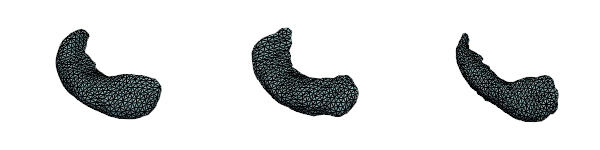

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


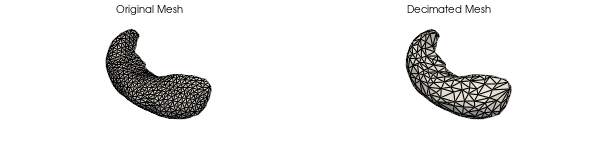

In [4]:
# Rigid alignment of all meshes to the first one of the pilot

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

all_meshes = prep_pipe([mesh for subject_id in ["01", "1001", "1004"] for mesh in raw_meshes[subject_id]])

registered_meshes = {
    "01": all_meshes[:n_meshes["01"]],
    "1001": all_meshes[n_meshes["01"]:n_meshes["01"] + n_meshes["1001"]],
    "1004": all_meshes[n_meshes["01"] + n_meshes["1001"]:],
}

pl = pv.Plotter(shape=(1,3), border=False, window_size=[600, 150])

pl.subplot(0,0)
pl.add_mesh(registered_meshes["01"][0], show_edges=True)

pl.subplot(0,1) 
pl.add_mesh(registered_meshes["1001"][0], show_edges=True)

pl.subplot(0,2)
pl.add_mesh(registered_meshes["1004"][0], show_edges=True)

pl.show()

meshes = {
    "01": [],
    "1001": [],
    "1004": [],
}
# Coarsen all meshes to reduce number of vertices
target_reduction = 0.6  # Reduce number of vertices by 50%

for subject_id in SUBJECT_IDS:
    for mesh in registered_meshes[subject_id]:        
        meshes[subject_id].append(mesh.decimate(target_reduction=target_reduction))
    meshes[subject_id] = np.array(meshes[subject_id])
# Visualize one example of decimated mesh
pl = pv.Plotter(shape=(1,2), border=False, window_size=[600, 150])

pl.subplot(0,0)
pl.add_mesh(registered_meshes["01"][0], show_edges=True, color='white')
pl.add_text("Original Mesh", position='upper_edge', font_size=4)

pl.subplot(0,1)
pl.add_mesh(meshes["01"][0], show_edges=True, color='white') 
pl.add_text("Decimated Mesh", position='upper_edge', font_size=4)

pl.show()


In [5]:
registration_kwargs = dict(
    kernel_width=10,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    # attachment_kernel_width=2.0,
    tol=1e-10,
    # filter_cp=True,
    # threshold=0.75,
)

In [6]:
# Compute subject specific deterministic atlas
templates = {
    "01": None,
    "1001": None,
    "1004": None,  # can't be hardcoded, even if there is only one pre- mesh in 1004, bcs of filenames
}

for subject_id in ["1001", "1004"]:  #["01", "1001", "1004"]:
    subject_csv = csvs[subject_id]
    subject_meshes = meshes[subject_id]
    assert len(subject_meshes) == len(subject_csv)
    pre_indices = subject_csv.reset_index().index[subject_csv["trimester"] == "pre"]
    # Select corresponding pre-pregnancy meshes
    pre_meshes = [subject_meshes[i] for i in pre_indices]
    print(f"Found {len(pre_meshes)} pre-pregnancy meshes")

    meshes_writer = Map(PvWriter(dirname=SUBJECT_ATLAS_DIR[subject_id], ext="vtk"))

    mesh_filenames = meshes_writer(
        [(f"premesh{subject_id}_{index}", mesh) for index, mesh in enumerate(pre_meshes)]
    )
    dataset = [{"shape": filename} for filename in mesh_filenames]

    lddmm.estimate_deterministic_atlas(
        source=dataset[0]["shape"],
        targets=dataset,
        subject_id="structure",  # WHY?
        output_dir=SUBJECT_ATLAS_DIR[subject_id],
        initial_step_size=1e-1,
        **registration_kwargs,
    )
    templates[subject_id] = PvReader()(SUBJECT_ATLAS_DIR[subject_id] / lddmm_strings.template_str)

Found 2 pre-pregnancy meshes
Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlases/subject1001_atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


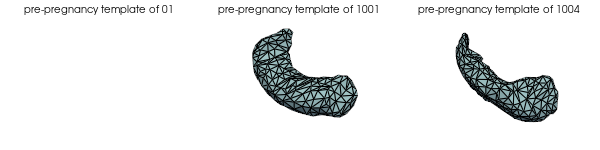

In [7]:
pl = pv.Plotter(shape=(1,3), border=False, window_size=[600, 150])

# First subplot empty
pl.subplot(0,0)
pl.add_text("pre-pregnancy template of 01", position='upper_edge', font_size=4)

# Second subplot - template 1001
pl.subplot(0,1)
pl.add_mesh(templates["1001"], show_edges=True)
pl.add_text("pre-pregnancy template of 1001", position='upper_edge', font_size=4)

# Third subplot - template 1004 
pl.subplot(0,2)
pl.add_mesh(templates["1004"], show_edges=True)
pl.add_text("pre-pregnancy template of 1004", position='upper_edge', font_size=4)

pl.show()

In [8]:
# compute global prepregnancy control deterministic atlas
templates["global"] = None

meshes_writer = Map(PvWriter(dirname=GLOBAL_ATLAS_DIR, ext="vtk"))

mesh_filenames = meshes_writer(
    [(f"template_{index}", mesh) for index, mesh in enumerate([templates["1001"], templates["1004"]])]
)
dataset = [{"shape": filename} for filename in mesh_filenames]

lddmm.estimate_deterministic_atlas(
    source=dataset[0]["shape"],
    targets=dataset,
    subject_id="structure",
    output_dir=GLOBAL_ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)
templates["global"] = PvReader()(GLOBAL_ATLAS_DIR / lddmm_strings.template_str)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlases/global_atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_meth

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


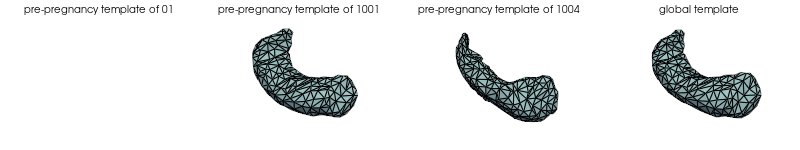

In [9]:
pl = pv.Plotter(shape=(1,4), border=False, window_size=[800, 150])

# First subplot empty
pl.subplot(0,0)
pl.add_text("pre-pregnancy template of 01", position='upper_edge', font_size=4)

# Second subplot - template 1001
pl.subplot(0,1)
pl.add_mesh(templates["1001"], show_edges=True)
pl.add_text("pre-pregnancy template of 1001", position='upper_edge', font_size=4)

# Third subplot - template 1004 
pl.subplot(0,2)
pl.add_mesh(templates["1004"], show_edges=True)
pl.add_text("pre-pregnancy template of 1004", position='upper_edge', font_size=4)

# Fourth subplot - global template
pl.subplot(0,3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position='upper_edge', font_size=4)

pl.show()

In [ ]:
# compute the deformation between the pre-pregnancy template of 01 and each mesh of 1001.
# one idea is to directly compute the difference, but it woujdn't use the control points
# This take 4 minutes
for subject_id in ["1001", "1004"]:
    for mesh in meshes[subject_id]:  # HACK FOR DEBUGGING
        
        meshes_writer = Map(PvWriter(dirname=SUBJECT_REGISTRATION_DIR[subject_id], ext="vtk"))

        mesh_filenames = meshes_writer(
        [(f"template_{index}", mesh) for index, mesh in enumerate([templates[subject_id], mesh])]
    )
        lddmm.registration.estimate_registration(
            source=mesh_filenames[0],  #template 
            target=mesh_filenames[1],
            output_dir=SUBJECT_REGISTRATION_DIR[subject_id],
            **registration_kwargs,
        )
# the control points are NOT the same for each subject at the end of the registration
# there's not even the same number of control points for each subject

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/registrations/subject1001_registrations/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -1.499E+01 	 [ attachment =

In [14]:
# parallel transport the momenta (?) of each subject from its subject-specific template to the global template

# 1. register global template to each subej
for subject_id in ["1001", "1004"]:
    reg_dir = REGISTRATIONS_DIR / f'global_to_{subject_id}'
    reg_dir.mkdir(parents=True, exist_ok=True)

    meshes_writer = Map(PvWriter(dirname=reg_dir, ext="vtk"))

    mesh_filenames = meshes_writer(
        [(f"template_{index}", mesh) for index, mesh in enumerate(
            [templates[subject_id], templates["global"]])]
    )

    lddmm.registration.estimate_registration(
        source=mesh_filenames[0], 
        target=mesh_filenames[1], 
        output_dir=reg_dir, 
        **registration_kwargs)
    
    transport_dir = RESULTS_DIR / f'transport_{subject_id}'
    transport_dir.mkdir(parents=True, exist_ok=True)

    control_points = (reg_dir / lddmm_strings.cp_str).as_posix()
    momenta = (reg_dir / lddmm_strings.momenta_str).as_posix()
    control_points_to_transport = (SUBJECT_REGISTRATION_DIR[subject_id] / lddmm_strings.cp_str).as_posix()
    momenta_to_transport = (SUBJECT_REGISTRATION_DIR[subject_id] / lddmm_strings.momenta_str).as_posix()

    n_rungs = 11
    transport_args = {"kernel_type": "torch", "kernel_width": 4, "n_rungs": n_rungs}

    cp, mom = lddmm.parallel_transport.transport(
        control_points=control_points, 
        momenta=momenta, 
        control_points_to_transport=control_points_to_transport, 
        momenta_to_transport=momenta_to_transport,
        transport_dir=transport_dir, 
        **transport_args)
    print("YES!!!!")

# 2. parallel transport the momenta of each subject from its subject-specific template to the global template


Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/registrations/global_to_1001/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -8.449E+01 	 [ attachment = -6.256E+01

AttributeError: module 'polpo.lddmm' has no attribute 'parallel_transport'

In [ ]:
from sklearn.linear_model import LinearRegression

X = []
y = []

for subject_id in ["1001", "1004"]:
    # Get pregnancy indices from CSV files
    subject_csv = csvs[subject_id]
    subject_momenta = momenta_from_subject_template[subject_id]
    assert len(subject_momenta) == len(subject_csv)
    pregnancy_indices = subject_csv.reset_index().index[subject_csv["stage"] == "preg"]
    # Select corresponding pre-pregnancy meshes
    pregnancy_momenta  = [subject_momenta[i] for i in pregnancy_indices]
    pregnancy_gestweek = subject_csv["gestWeek"][subject_csv["stage"] == "preg"].tolist()
    assert len(pregnancy_gestweek) == len(pregnancy_momenta)
    print(f"Found {len(pregnancy_momenta)} pregnancy momenta")
    y.extend(pregnancy_gestweek)
    X.extend(pregnancy_momenta)


X = np.array(X).reshape(len(y), -1)
y = np.array(y)

# Standardize y to have zero mean and unit variance
y = (y - np.mean(y)) / np.std(y)


print(X.shape)
print(y.shape)

Found 7 pregnancy momenta
Found 14 pregnancy momenta
(21, 72)
(21,)


In [ ]:
# Train-test split and regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

print(f"Regression coefficients: {regression.coef_}")
print(f"Regression intercept: {regression.intercept_}")
print(f"Train R2 score: {train_r2:.3f}")
print(f"Test R2 score: {test_r2:.3f}")


Regression coefficients: [-0.0475128  -0.20793428  0.12518647 -0.40066458 -0.30088703  0.13057257
  0.11033436  0.17746964  0.16130291  0.37172321  0.04971518 -0.1947087
  0.00707097  0.04679694 -0.14465205 -0.06615254  0.02296597 -0.03906212
 -0.15404887 -0.09492599 -0.08598621 -0.20808952  0.1928069   0.20513928
  0.08681601  0.01675351 -0.04860588  0.05266796 -0.14478317  0.02885679
 -0.03100625  0.04538691 -0.10291122 -0.00315975 -0.10886183  0.15149466
  0.0970834  -0.0382668   0.08020802 -0.11975142  0.10791238 -0.13274261
  0.02983922 -0.14670629  0.0763163   0.11544306  0.00725577 -0.02045337
  0.09999708 -0.0052859   0.12839739 -0.02726886  0.07361428 -0.146344
  0.12439884 -0.17373766 -0.12048952  0.18532592 -0.20879205 -0.03906035
 -0.13822599  0.16314038 -0.00389031  0.09263556 -0.0472091   0.04504123
 -0.04774953  0.03857911  0.09940681 -0.03347729 -0.11363047 -0.09416703]
Regression intercept: 0.5789366094388145
Train R2 score: 1.000
Test R2 score: -1.999
